<a href="https://colab.research.google.com/github/Aditi3100/Automatic_pause_play_video_using_haar_cascades/blob/master/FraudDetection/Rule-Based%20Tagging/RuleBasedAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Data Uploading

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import statistics
from sklearn.cluster import DBSCAN
import math

In [3]:
! pip install -q kaggle
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                           title                                              size  lastUpdated          downloadCount  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                   Reddit Vaccine Myths                              231KB  2021-06-22 06:09:25           8125  
crowww/a-large-scale-fish-dataset                             A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4992  
imsparsh/musicnet-dataset                                     MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1689  
dhruvildave/wikibooks-dataset                                 Wikibooks Dataset                                   1GB  2021-06-21 13:35:12           2279  
mathurinache/twitter-edge-node

In [4]:
!kaggle datasets download -d aditinath/creditcardtransactions

 85% 50.0M/58.9M [00:00<00:00, 72.2MB/s]
100% 58.9M/58.9M [00:00<00:00, 92.7MB/s]


In [5]:
!unzip /content/creditcardtransactions.zip

Archive:  /content/creditcardtransactions.zip
  inflating: CCDMS_dataset.csv       


In [6]:
path = "/content/CCDMS_dataset.csv"
dataset = pd.read_csv(path)
dataset.shape

(555718, 25)

In [7]:
df = pd.DataFrame(dataset[['trans_date_trans_time', 'card_num', 'merchant',
       'purchase_category', 'trans_amt', 'first', 'last', 'gender',
       'city', 'state', 'lat', 'long', 'city_pop', 'job', 'dob', 'unix_time', 'merch_lat', 'merch_long']])
df.head()

,trans_date_trans_time,card_num,merchant,purchase_category,trans_amt,first,last,gender,city,state,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long
0,6/21/2020 12:14,3573030041201290,Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,Altonah,UT,40.3207,-110.4360,302,"Sales professional, IT",1/17/1990,1371816873,39.450498,-109.960431
1,6/21/2020 12:14,3598215285024750,"Swaniawski, Nitzsche and Welch",health,41.28,Ashley,Lopez,F,Bellmore,NY,40.6729,-73.5365,34496,"Librarian, public",10/21/1970,1371816893,40.495810,-74.196111
2,6/21/2020 12:15,3591919803438420,Haley Group,misc_pos,60.05,Brian,Williams,M,Titusville,FL,28.5697,-80.8191,54767,Set designer,7/25/1987,1371816915,28.812398,-80.883061
3,6/21/2020 12:15,3526826139003040,Johnston-Casper,travel,3.19,Nathan,Massey,M,Falmouth,MI,44.2529,-85.0170,1126,Furniture designer,7/6/1955,1371816917,44.959148,-85.884734
4,6/21/2020 12:15,30407675418785,Daugherty LLC,kids_pets,19.55,Danielle,Evans,F,Breesport,NY,42.1939,-76.7361,520,Psychotherapist,10/13/1991,1371816937,41.747157,-77.584197


In [8]:
lst = list(list(str(df.iloc[i]['trans_date_trans_time']).split(' ')) for i in df.index)
lst[0:5]

[['6/21/2020', '12:14'],
 ['6/21/2020', '12:14'],
 ['6/21/2020', '12:15'],
 ['6/21/2020', '12:15'],
 ['6/21/2020', '12:15']]

In [9]:
lst = pd.DataFrame(lst)
df['trans_date']=lst[0]
df['trans_time']=lst[1]
df.drop(['trans_date_trans_time'],inplace=True,axis=1)
df.head()

,card_num,merchant,purchase_category,trans_amt,first,last,gender,city,state,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,trans_date,trans_time
0,3573030041201290,Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,Altonah,UT,40.3207,-110.4360,302,"Sales professional, IT",1/17/1990,1371816873,39.450498,-109.960431,6/21/2020,12:14
1,3598215285024750,"Swaniawski, Nitzsche and Welch",health,41.28,Ashley,Lopez,F,Bellmore,NY,40.6729,-73.5365,34496,"Librarian, public",10/21/1970,1371816893,40.495810,-74.196111,6/21/2020,12:14
2,3591919803438420,Haley Group,misc_pos,60.05,Brian,Williams,M,Titusville,FL,28.5697,-80.8191,54767,Set designer,7/25/1987,1371816915,28.812398,-80.883061,6/21/2020,12:15
3,3526826139003040,Johnston-Casper,travel,3.19,Nathan,Massey,M,Falmouth,MI,44.2529,-85.0170,1126,Furniture designer,7/6/1955,1371816917,44.959148,-85.884734,6/21/2020,12:15
4,30407675418785,Daugherty LLC,kids_pets,19.55,Danielle,Evans,F,Breesport,NY,42.1939,-76.7361,520,Psychotherapist,10/13/1991,1371816937,41.747157,-77.584197,6/21/2020,12:15


In [10]:
import time, datetime
def convertTime(t):
    x = time.strptime(t,'%H:%M')
    return str(int(datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min).total_seconds()/60))

In [11]:
df.trans_time=df.trans_time.apply(convertTime)

In [12]:
df['trans_date'] = pd.to_datetime(df['trans_date']).dt.date

In [13]:
df["trans_date"] = pd.to_datetime(df["trans_date"]).dt.strftime("%Y%m%d")

In [14]:
df.shape

(555718, 19)

In [15]:
df.columns

Index(['card_num', 'merchant', 'purchase_category', 'trans_amt', 'first',
       'last', 'gender', 'city', 'state', 'lat', 'long', 'city_pop', 'job',
       'dob', 'unix_time', 'merch_lat', 'merch_long', 'trans_date',
       'trans_time'],
      dtype='object')

In [16]:
df.head()

,card_num,merchant,purchase_category,trans_amt,first,last,gender,city,state,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,trans_date,trans_time
0,3573030041201290,Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,Altonah,UT,40.3207,-110.4360,302,"Sales professional, IT",1/17/1990,1371816873,39.450498,-109.960431,20200621,734
1,3598215285024750,"Swaniawski, Nitzsche and Welch",health,41.28,Ashley,Lopez,F,Bellmore,NY,40.6729,-73.5365,34496,"Librarian, public",10/21/1970,1371816893,40.495810,-74.196111,20200621,734
2,3591919803438420,Haley Group,misc_pos,60.05,Brian,Williams,M,Titusville,FL,28.5697,-80.8191,54767,Set designer,7/25/1987,1371816915,28.812398,-80.883061,20200621,735
3,3526826139003040,Johnston-Casper,travel,3.19,Nathan,Massey,M,Falmouth,MI,44.2529,-85.0170,1126,Furniture designer,7/6/1955,1371816917,44.959148,-85.884734,20200621,735
4,30407675418785,Daugherty LLC,kids_pets,19.55,Danielle,Evans,F,Breesport,NY,42.1939,-76.7361,520,Psychotherapist,10/13/1991,1371816937,41.747157,-77.584197,20200621,735


In [17]:
card_list = df['card_num'].unique()
len(card_list)

925

In [18]:
df_num=pd.DataFrame()
df_num['num_trans']=df.groupby(['card_num']).agg(len)['merchant']
df_num.sort_values('num_trans')

,num_trans
card_num,
456000414998386,1
4295296907373,6
4352307151555400000,7
3540416671210050,8
4883407061576,9
...,...
2242542703101230,1428
4587657402165340000,1458
4745996322265,1462


In [19]:
df_test1 = pd.DataFrame(df[df['card_num']==card_list[830]])
df_test1.head()
print(len(df_test1))

236


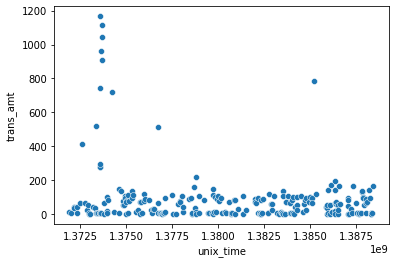

In [20]:
sns.scatterplot(x=df_test1['unix_time'],y=df_test1['trans_amt'])

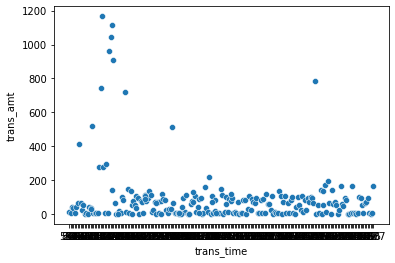

In [21]:
sns.scatterplot(x=df_test1['trans_time'],y=df_test1['trans_amt'])

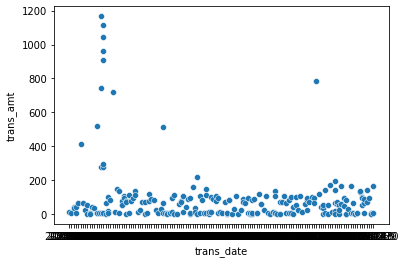

In [22]:
sns.scatterplot(x=df_test1['trans_date'],y=df_test1['trans_amt'])

#**Analysis**

##Aggregating credit card data for each card

####Clustering

In [23]:
test_df1 = pd.DataFrame(df_test1[['unix_time','trans_amt']])
test_df1.head()

,unix_time,trans_amt
3234,1371892809,11.43
7864,1371993945,9.11
12152,1372134366,44.96
13071,1372174837,38.17
16674,1372309844,9.03


In [24]:
n = math.ceil(len(test_df1)/6)
clus_km = KMeans(n_clusters = n).fit(test_df1)
data = clus_km.cluster_centers_
len(data)

40

In [25]:
scaler = StandardScaler()
data2 = scaler.fit_transform(test_df1)
data2 = pd.DataFrame(data2)
data2.head()

,0,1
0,-1.672725,-0.447421
1,-1.652849,-0.460653
2,-1.625254,-0.256197
3,-1.617300,-0.294921
4,-1.590769,-0.461109


In [26]:
dist = pairwise_distances(data2,metric='euclidean')
dist = dist.reshape(1,-1)
dist[0].shape
print(statistics.median(dist[0]))

1.217647315065428


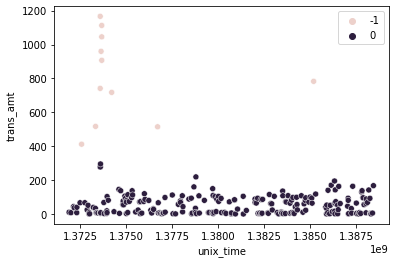

In [27]:
eps = statistics.median(dist[0]) if statistics.median(dist[0])/2 else 1
clus_db = DBSCAN(min_samples = 50, eps=eps).fit_predict(data2)
sns.scatterplot(x=test_df1['unix_time'],y=test_df1['trans_amt'], hue= clus_db)

In [28]:
df3 = pd.DataFrame(df)

In [29]:
df3['cluster'] = [0]*len(df)

In [32]:
for card in card_list:
  df_temp = df3[df3['card_num']==card][['unix_time','trans_amt']]
  
  scaler = StandardScaler()
  data2 = scaler.fit_transform(df_temp)
  data2 = pd.DataFrame(data2)
  dist = pairwise_distances(data2,metric='euclidean')
  dist = dist[0].reshape(1,-1)
  dist = np.sort(dist[0])
  eps = dist[len(dist)//2]
  eps = eps or 1
  clus_db = DBSCAN(min_samples = 25, eps=eps).fit_predict(data2)
  df3.loc[df_temp.index,'cluster'] = clus_db

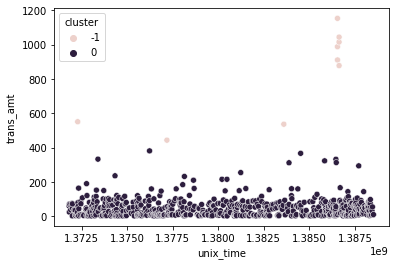

In [33]:
df_test3 = df3[df3['card_num']==card_list[2]]
sns.scatterplot(x=df_test3['unix_time'],y=df_test3['trans_amt'], hue = df_test3['cluster'])

####Large number of Transactions in short interval of time, Transactions of large amounts

In [34]:
min1 = min(df_test1['unix_time'])
df_test1['adj_time']= df_test1['unix_time']-min1
#min1 = min(test_df['adj_time'])
df_test1['adj_time']= df_test1['adj_time']//3600

In [35]:
n_bins = max(df_test1['adj_time'])
discretizer = KBinsDiscretizer(n_bins=n_bins,encode='ordinal',strategy='uniform')
b = df_test1['adj_time']
b=np.sort(b)
data = b.reshape(-1,1)
discretizer.fit(data)
classes = (discretizer.transform(data)).reshape(1,-1)[0]
clusters = []
for val in range(n_bins):
  clusterI = list(i for i in range(len(classes)) if classes[i]==val )
  clusters.append(clusterI)
#print(list(len(c) for c in clusters ))

In [36]:
edges = discretizer.bin_edges_[0]
edges

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.593e+03, 4.594e+03,
       4.595e+03])

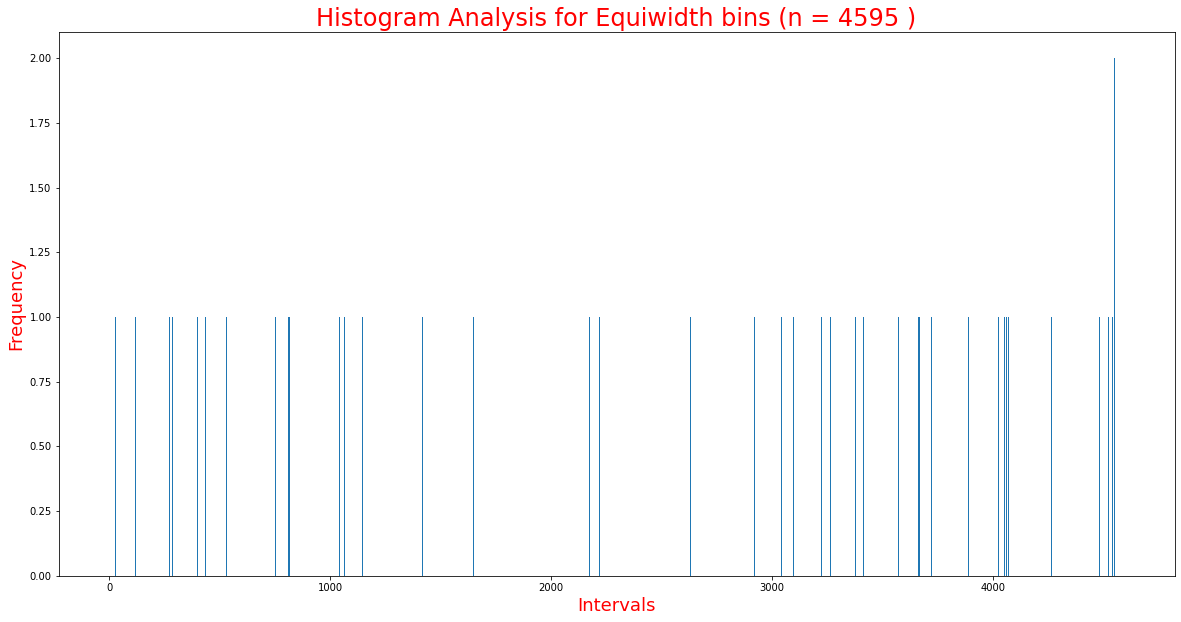

In [37]:
heights = np.array(list(len(c) for c in clusters))
#labels = list(str(str(edges[i]) + '-' + str(edges[i+1])) for i in range(0,n_bins))

plt.figure(figsize=(20,10))
plt.title('Histogram Analysis for Equiwidth bins (n = '+str(n_bins)+' )', fontsize=24, color='red')
x = np.arange(n_bins)
plt.xlabel('Intervals', fontsize=18, color='red')
plt.ylabel('Frequency', fontsize=18, color='red')
plt.bar(x, heights)
#plt.savefig(attr+'histEquiWidth')
plt.show()

In [38]:
freq_q = pd.Series(heights[heights>0]).quantile(q=[0.25,0.5, 0.75], interpolation='midpoint')
freq_q

0.25    1.0
0.50    1.0
0.75    1.0
dtype: float64

In [39]:
amt_q = df_test1.quantile(q=[0.25,0.5,0.75], axis=0, numeric_only=True, interpolation='midpoint')['trans_amt']
amt_q

0.25     8.155
0.50    53.255
0.75    94.485
Name: trans_amt, dtype: float64

In [40]:
df_test1['bin'] = classes
c_map = []
for i in range(len(df_test1)):
    ind = df_test1['bin'].iloc[i]
    if df_test1.iloc[i]['trans_amt']>amt_q[0.5]*3 and heights[int(ind)]>freq_q[0.75]:
        c_map.append(3)
    elif heights[int(ind)]>=freq_q[0.5]*2:
        c_map.append(2)
    elif df_test1.iloc[i]['trans_amt']>amt_q[0.5]*5:
        c_map.append(1)
    else:
        c_map.append(0)
len(c_map)

236

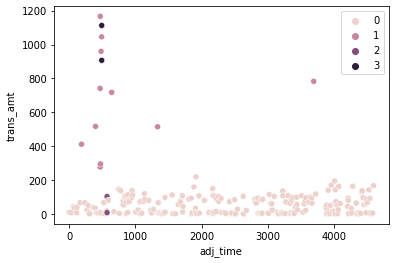

In [41]:
sns.scatterplot(x=df_test1['adj_time'],y=df_test1['trans_amt'], hue=c_map)

In [42]:
df3['amt_int'] = [0]*len(df)
for card in card_list:
  df_temp = df3[df3.card_num == card]
  if len(df_temp)<2:
    df3.loc[df_temp.index,'amt_int'] = 1
    continue
    
  min1 = min(df_temp['unix_time'])
  df_temp['adj_time']= df_temp['unix_time']-min1
  df_temp['adj_time']= df_temp['adj_time']//3600
  
  n_bins = max(df_temp['adj_time'])
  discretizer = KBinsDiscretizer(n_bins=n_bins,encode='ordinal',strategy='uniform')
  b = df_temp['adj_time']
  b=np.sort(b)
  data = b.reshape(-1,1)
  discretizer.fit(data)
  classes = (discretizer.transform(data)).reshape(1,-1)[0]
  clusters = []
  for val in range(n_bins):
    clusterI = list(i for i in range(len(classes)) if classes[i]==val )
    clusters.append(clusterI)
  heights = np.array(list(len(c) for c in clusters))

  freq_q = pd.Series(heights[heights>0]).quantile(q=[0.25,0.5, 0.75], interpolation='midpoint')
  amt_q = df_test1.quantile(q=[0.25,0.5,0.75], axis=0, numeric_only=True, interpolation='midpoint')['trans_amt']

  df_temp['bin'] = classes
  c_map = []
  for i in range(len(df_temp)):
    ind = df_temp['bin'].iloc[i]
    if df_temp.iloc[i]['trans_amt']>amt_q[0.5]*3 and heights[int(ind)]>freq_q[0.75]:
        c_map.append(3)
    elif heights[int(ind)]>=freq_q[0.5]*2:
        c_map.append(1)
    elif df_temp.iloc[i]['trans_amt']>amt_q[0.5]*5:
        c_map.append(2)
    else:
        c_map.append(0)
  df3.loc[df_temp.index,'amt_int'] = c_map  
  


Streaming output truncated to the last 5000 lines.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python

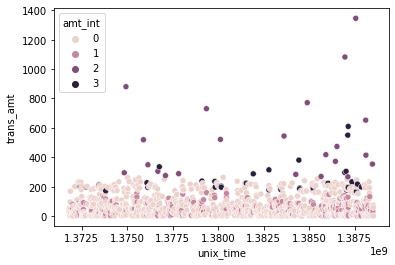

In [43]:
df_test3 = df3[df3['card_num']==card_list[1]]
sns.scatterplot(x=df_test3['unix_time'],y=df_test3['trans_amt'], hue = df_test3['amt_int'])

###Location based

####Distance between consecutive transaction wrt to time difference

In [44]:
def calc_dist(lata,lona,latb,lonb):
    R = 6373.0
    lat1 = math.radians(lata)
    lon1 = math.radians(lona)
    lat2 = math.radians(latb)
    lon2 = math.radians(lonb)
    
    dlon = lon2-lon1
    dlat = lat2-lat1
    
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2*math.atan2(math.sqrt(a),math.sqrt(1-a))
    
    return (R*c)

In [45]:
def calc_speed_col(X):
    speed = [0]
    for i in range(1,len(X)):
        d = calc_dist(X.iloc[i-1]['merch_lat'],X.iloc[i-1]['merch_long'],X.iloc[i]['merch_lat'],X.iloc[i]['merch_long'])
        dt = (X.iloc[i]['unix_time'] - X.iloc[i-1]['unix_time'])/3600
        speed.append(d/dt)
    return speed

In [46]:
df_test1['speed(km/hr)'] = calc_speed_col(df_test1)
df_test1.head(50)

,card_num,merchant,purchase_category,trans_amt,first,last,gender,city,state,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,trans_date,trans_time,adj_time,bin,speed(km/hr)
3234,501882822387,Terry-Huel,shopping_net,11.43,Melissa,Phillips,F,Meadville,MS,31.4285,-90.8578,2799,"Therapist, horticultural",1/21/1961,1371892809,31.307457,-90.751934,20200622,560,0,0.0,0.000000
7864,501882822387,Thiel Ltd,travel,9.11,Melissa,Phillips,F,Meadville,MS,31.4285,-90.8578,2799,"Therapist, horticultural",1/21/1961,1371993945,31.607507,-91.235348,20200623,805,28,28.0,2.019141
12152,501882822387,"Labadie, Treutel and Bode",shopping_net,44.96,Melissa,Phillips,F,Meadville,MS,31.4285,-90.8578,2799,"Therapist, horticultural",1/21/1961,1372134366,31.222088,-91.474550,20200625,266,67,67.0,1.243712
13071,501882822387,"Witting, Beer and Ernser",home,38.17,Melissa,Phillips,F,Meadville,MS,31.4285,-90.8578,2799,"Therapist, horticultural",1/21/1961,1372174837,30.663531,-91.845680,20200625,940,78,78.0,6.360859
16674,501882822387,Pacocha-Bauch,shopping_pos,9.03,Melissa,Phillips,F,Meadville,MS,31.4285,-90.8578,2799,"Therapist, horticultural",1/21/1961,1372309844,31.680250,-90.535722,20200627,310,115,115.0,4.488217
16878,501882822387,Cruickshank-Mills,entertainment,41.01,Melissa,Phillips,F,Meadville,MS,31.4285,-90.8578,2799,"Therapist, horticultural",1/21/1961,1372319596,31.561414,-90.582111,20200627,473,118,118.0,5.142050
22977,501882822387,Cummerata-Jones,gas_transport,67.60,Melissa,Phillips,F,Meadville,MS,31.4285,-90.8578,2799,"Therapist, horticultural",1/21/1961,1372487778,32.100604,-90.910763,20200629,396,165,165.0,1.445692
26941,501882822387,Gutmann-Upton,misc_pos,412.61,Melissa,Phillips,F,Meadville,MS,31.4285,-90.8578,2799,"Therapist, horticultural",1/21/1961,1372571912,31.773681,-90.930584,20200630,358,188,188.0,1.558016
32405,501882822387,Hudson-Ratke,grocery_pos,67.82,Melissa,Phillips,F,Meadville,MS,31.4285,-90.8578,2799,"Therapist, horticultural",1/21/1961,1372749281,31.182925,-90.472555,20200702,434,237,237.0,1.598876
35468,501882822387,"Schoen, Nienow and Bauch",personal_care,26.05,Melissa,Phillips,F,Meadville,MS,31.4285,-90.8578,2799,"Therapist, horticultural",1/21/1961,1372873049,31.785064,-89.997367,20200703,1057,272,272.0,2.348178


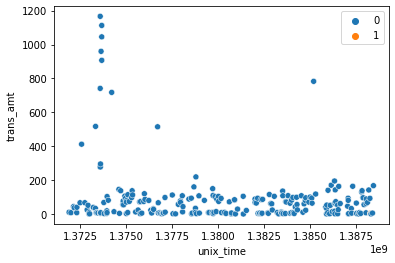

In [47]:
speed_v = []
for i in range(len(df_test1)):
    if df_test1.iloc[i]['speed(km/hr)']>600:
        speed_v.append(1)
    else:
        speed_v.append(0)
sns.scatterplot(x=test_df1['unix_time'],y=test_df1['trans_amt'], hue= speed_v)

In [48]:
df3['over_speed'] = [0]*len(df)
for card in card_list:
  df_temp = df3[df3.card_num == card][['unix_time','trans_amt','merch_lat','merch_long']]
  df_temp['speed(km/hr)'] = calc_speed_col(df_temp)
  speed_v = []
  for i in range(len(df_temp)):
    if df_temp.iloc[i]['speed(km/hr)']>600:
        speed_v.append(1)
    else:
        speed_v.append(0)
  df3.loc[df_temp.index,'over_speed'] = speed_v

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encounter

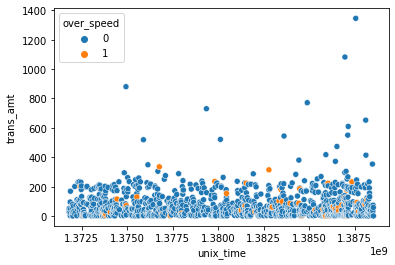

In [49]:
df_test3 = df3[df3['card_num']==card_list[1]]
sns.scatterplot(x=df_test3['unix_time'],y=df_test3['trans_amt'], hue = df_test3['over_speed'])

####Merchant Location

In [50]:
scaler1 = StandardScaler()
data_m = scaler1.fit_transform(df_test1[['merch_lat','merch_long']])
data_m = pd.DataFrame(data_m)
data_m.head()

,0,1
0,-0.305460,0.146597
1,0.223683,-0.720454
2,-0.456010,-1.149487
3,-1.441035,-1.815146
4,0.351967,0.534395


In [51]:
dist = pairwise_distances(data_m,metric='euclidean')
dist = dist.reshape(1,-1)
dist[0].shape
print(statistics.median(dist[0]))

1.7550324394236596


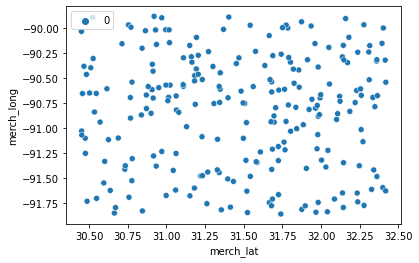

In [52]:
from sklearn.cluster import DBSCAN
clus_ml = DBSCAN(min_samples = 50, eps=statistics.median(dist[0])).fit_predict(data_m)
sns.scatterplot(x=df_test1['merch_lat'],y=df_test1['merch_long'], hue= clus_ml)

####Merchant distance from customer wrt trans_amt

In [53]:
dist_cm = np.zeros(len(df_test1))
for i in range(len(df_test1)):
    row = df_test1.iloc[i]
    dist_cm[i] = (calc_dist(row['lat'],row['long'],row['merch_lat'],row['merch_long']))
df_test1['dist']=dist_cm

In [54]:
scaler2 = StandardScaler()
data_s = scaler2.fit_transform(df_test1[['trans_amt','dist']])
data_s = pd.DataFrame(data_s)
data_s.head()

,0,1
0,-0.447421,-2.024670
1,-0.460653,-1.212230
2,-0.256197,-0.473308
3,-0.294921,1.677354
4,-0.461109,-1.196711


In [55]:
dist = pairwise_distances(data_s,metric='euclidean')
dist = dist.reshape(1,-1)
dist[0].shape
print(statistics.median(dist[0]))

1.225803521827916


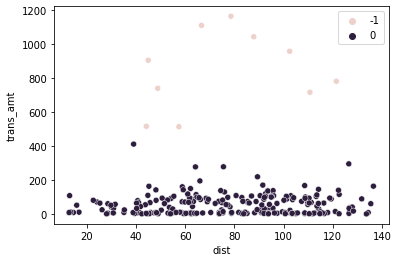

In [56]:
clus_ml = DBSCAN(min_samples = 25, eps=statistics.median(dist[0])).fit_predict(data_s)
sns.scatterplot(x=df_test1['dist'],y=df_test1['trans_amt'], hue= clus_ml)

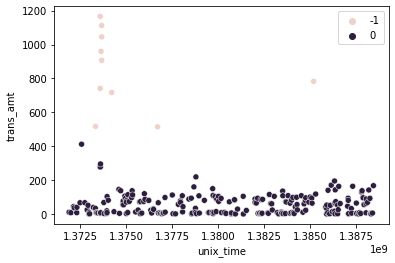

In [57]:
sns.scatterplot(x=df_test1['unix_time'],y=df_test1['trans_amt'], hue= clus_ml)

In [59]:
df3['clus_ml'] = [0]*len(df3)
for card in card_list[0:100]:
  df_temp = df3[df3['card_num']==card]
  
  dist_cm = np.zeros(len(df_temp))
  for i in range(len(df_temp)):
    row = df_temp.iloc[i]
    dist_cm[i] = (calc_dist(row['lat'],row['long'],row['merch_lat'],row['merch_long']))
  df_temp['dist']=dist_cm

  scaler2 = StandardScaler()
  data_s = scaler2.fit_transform(df_temp[['dist','trans_amt']])
  data_s = pd.DataFrame(data_s)

  dist = pairwise_distances(data_s,metric='euclidean')
  dist = dist.reshape(1,-1)
  dist = np.sort(dist[0])

  eps = dist[len(dist)//2]
  clus_db = DBSCAN(min_samples = 25, eps=(eps or 1)).fit_predict(data_s)

  df3.loc[df_temp.index,'clus_ml'] = clus_db

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

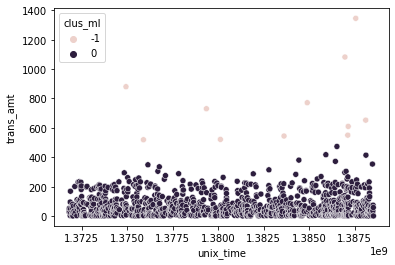

In [60]:
df_test3 = df3[df3['card_num']==card_list[1]]
sns.scatterplot(x=df_test3['unix_time'],y=df_test3['trans_amt'], hue = df_test3['clus_ml'])

###Purchase Category

In [61]:
df_pc = pd.DataFrame()
df_pc['mean_spenditure'] = df_test1.groupby('purchase_category').agg(np.mean)['trans_amt']
df_pc['count'] = df_test1.groupby('purchase_category').agg(len)['trans_amt']
df_pc.head(14)

,mean_spenditure,count
purchase_category,,
entertainment,44.981333,15.0
food,79.554444,9.0
gas_transport,72.536538,26.0
grocery_net,78.016000,5.0
grocery_pos,110.262963,27.0
health,60.337500,8.0
home,62.739091,22.0
kids_pets,89.025000,16.0
misc_net,97.345000,10.0


In [62]:
df_test1['above_cat_mean'] = [0]*len(df_test1)

In [63]:
for cat in df_pc.index:
    
    for i in [df_test1[df_test1['purchase_category']==cat][df_test1['trans_amt']>5*df_pc.loc[cat]['mean_spenditure']].index]:
        df_test1.loc[i,'above_cat_mean']=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexe

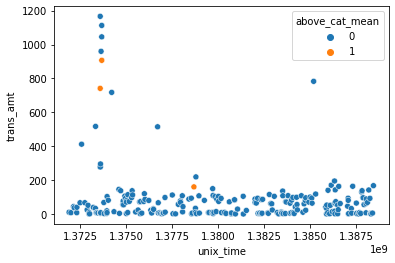

In [64]:
 sns.scatterplot(x=df_test1['unix_time'],y=df_test1['trans_amt'],hue = df_test1['above_cat_mean'])

In [65]:
df3['category_mean'] = [0]*len(df)
for card in card_list[0:100]:
  df_temp = df3[df3.card_num == card]
  df_pc = pd.DataFrame()
  df_pc['mean_spenditure'] = df_temp.groupby('purchase_category').agg(np.mean)['trans_amt']
  df_temp['above_cat_mean'] = [0]*len(df_temp)
  for cat in df_pc.index:
    for i in [df_temp[df_temp['purchase_category']==cat][df_temp['trans_amt']>5*df_pc.loc[cat]['mean_spenditure']].index]:
        df_temp.loc[i,'above_cat_mean']=1
  df3.loc[df_temp.index, 'category_mean'] = df_temp['above_cat_mean']

Streaming output truncated to the last 5000 lines.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:176

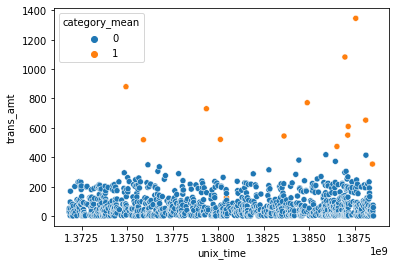

In [66]:
df_test3 = df3[df3['card_num']==card_list[1]]
sns.scatterplot(x=df_test3['unix_time'],y=df_test3['trans_amt'], hue = df_test3['category_mean'])

###Job

In [67]:
df1 = pd.DataFrame(df, columns=['card_num', 'trans_amt', 'first',
       'last', 'gender', 'city', 'state', 'lat', 'long', 'city_pop', 'job',
       'dob'])
num = df1[['card_num','trans_amt']].groupby(['card_num']).mean()
df1.drop(['trans_amt'],axis=1,inplace=True)
df1.drop_duplicates(inplace=True)
df1.head()

,card_num,first,last,gender,city,state,lat,long,city_pop,job,dob
0,3573030041201290,Joanne,Williams,F,Altonah,UT,40.3207,-110.4360,302,"Sales professional, IT",1/17/1990
1,3598215285024750,Ashley,Lopez,F,Bellmore,NY,40.6729,-73.5365,34496,"Librarian, public",10/21/1970
2,3591919803438420,Brian,Williams,M,Titusville,FL,28.5697,-80.8191,54767,Set designer,7/25/1987
3,3526826139003040,Nathan,Massey,M,Falmouth,MI,44.2529,-85.0170,1126,Furniture designer,7/6/1955
4,30407675418785,Danielle,Evans,F,Breesport,NY,42.1939,-76.7361,520,Psychotherapist,10/13/1991


In [68]:
df1['trans_amt'] = list(num['trans_amt'])
df1.head()

,card_num,first,last,gender,city,state,lat,long,city_pop,job,dob,trans_amt
0,3573030041201290,Joanne,Williams,F,Altonah,UT,40.3207,-110.4360,302,"Sales professional, IT",1/17/1990,66.499484
1,3598215285024750,Ashley,Lopez,F,Bellmore,NY,40.6729,-73.5365,34496,"Librarian, public",10/21/1970,57.433109
2,3591919803438420,Brian,Williams,M,Titusville,FL,28.5697,-80.8191,54767,Set designer,7/25/1987,54.613684
3,3526826139003040,Nathan,Massey,M,Falmouth,MI,44.2529,-85.0170,1126,Furniture designer,7/6/1955,96.435535
4,30407675418785,Danielle,Evans,F,Breesport,NY,42.1939,-76.7361,520,Psychotherapist,10/13/1991,91.845732


In [69]:
job_mean = df1[['job','trans_amt']].groupby(['job']).mean()
job_mean

,trans_amt
job,
Academic librarian,57.979767
"Accountant, chartered certified",61.921874
"Accountant, chartered public finance",78.280989
Accounting technician,71.419512
Acupuncturist,61.390797
...,...
Water engineer,71.163836
Water quality scientist,86.940433
Web designer,75.841872


In [70]:
df2 = pd.DataFrame(df[['trans_date','trans_time', 'card_num', 'merchant',
       'purchase_category', 'trans_amt', 'first', 'last', 'gender',
       'city', 'state', 'lat', 'long', 'city_pop', 'job', 'dob', 'unix_time', 'merch_lat', 'merch_long']])
df2['above_job_mean'] = [0]*len(df2)

In [71]:
for i in range(len(job_mean)):
    prof = job_mean.index[i]
    for i in [df2[df2['job']==prof][df2['trans_amt']>5*job_mean.loc[prof]['trans_amt']].index]:
        df2.loc[i,'above_job_mean']=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexe

In [72]:
prof = job_mean.index[0]
lst = df2[df2['job']==prof][df2['trans_amt']>5*job_mean.loc[prof]['trans_amt']]['card_num'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [73]:
lst

array([4383521454815])

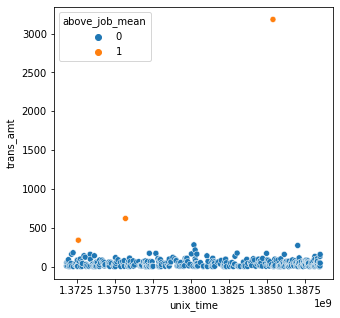

In [74]:
fig, axs = plt.subplots(len(lst),1)
fig.set_size_inches(5,5*len(lst))
i=0
for num in lst:
    df_test = df2[df2['card_num']==num]
    sns.scatterplot(ax=axs,x=df_test['unix_time'],y=df_test['trans_amt'],hue = df_test['above_job_mean'])
    i += 1

In [75]:
df_test2 = pd.DataFrame(df2[df2['card_num']==4613314721966])
df_test2.head()
print(len(df_test2))

681


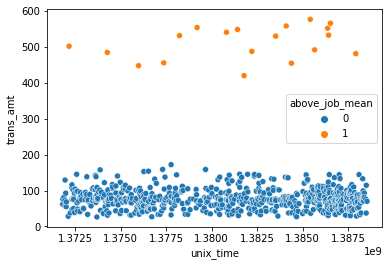

In [76]:
sns.scatterplot(x=df_test2['unix_time'],y=df_test2['trans_amt'],hue = df_test2['above_job_mean'])

In [77]:
df2['above_job_mean']

0         0
1         0
2         0
3         0
4         0
         ..
555713    0
555714    0
555715    0
555716    0
555717    0
Name: above_job_mean, Length: 555718, dtype: int64

In [78]:
df3['above_job_mean'] = df2['above_job_mean']

In [79]:
df3['above_job_mean']

0         0
1         0
2         0
3         0
4         0
         ..
555713    0
555714    0
555715    0
555716    0
555717    0
Name: above_job_mean, Length: 555718, dtype: int64